In [1]:
%%bash
!(stat -t /usr/local/lib/*/dist-packages/google/colab > /dev/null 2>&1) && exit 
rm -rf hw3
git clone https://github.com/mit-6864/hw3.git

Cloning into 'hw3'...


# Part 1: Experiments with DistilBERT
In this section, we will use our review dataset from HW1 and use a transformer based model, Distilbert, to see if it can perform better at the classification task. 

There isn't much implemention here, but we hope that you play around with the parameters and see how to use similar transformer models for custom datasets!

## HuggingFace
Hugging Face is a large open-source community for NLP research, and a great resource for pre-trained deep learning models. The Transformers library written in Python exposes a well-developed API to a plethora of deep learning architectures for SOTA performance in many NLP tasks. 

## Why DistilBERT 
The DistilBERT model was proposed in the paper [DistilBERT, a distilled version of BERT: smaller, faster, cheaper and lighter](https://arxiv.org/abs/1910.01108). DistilBERT is a small, fast, cheap and light Transformer model trained by distilling BERT base. It has 40% less parameters than bert-base-uncased, runs 60% faster while preserving over 95% of BERT’s performances as measured on the GLUE language understanding benchmark.

In [2]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Processing Data

In order to fine-tune a pretrained DistilBERT model, we must transform our dataset into the format that BERT can be trained on.

In [3]:
import sys
sys.path.append("hw3")

import csv
import itertools as it
import numpy as np
import sklearn.decomposition
np.random.seed(0)
from tqdm import tqdm

import lab_util

In [4]:

data = []
n_positive = 0
n_disp = 0
with open("/content/hw3/reviews.csv") as reader:
  csvreader = csv.reader(reader)
  next(csvreader)
  for id, review, label in csvreader:
    label = int(label)

    # hacky class balancing
    if label == 1:
      if n_positive == 2000:
        continue
      n_positive += 1
    if len(data) == 4000:
      break

    data.append((review, label))
    
    if n_disp > 5:
      continue
    n_disp += 1
    print("review:", review)
    print("rating:", label, "(good)" if label == 1 else "(bad)")
    print()

print(f"Read {len(data)} total reviews.")
np.random.shuffle(data)
reviews, labels = zip(*data)
train_reviews, train_labels = list(reviews[:3000]), list(labels[:3000])
val_reviews, val_labels = list(reviews[3000:3500]), list(labels[3000:3500])
test_reviews, test_labels = list(reviews[3500:]), list(labels[3500:])

review: I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.
rating: 1 (good)

review: Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as "Jumbo".
rating: 0 (bad)

review: This is a confection that has been around a few centuries.  It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with powdered sugar.  And it is a tiny mouthful of heaven.  Not too chewy, and very flavorful.  I highly recommend this yummy treat.  If you are familiar with the story of C.S. Lewis' "The Lion, The Witch, and The Wardrobe" - this is the treat that seduces Edmund into selling out his Brother an

## Tokenizer

To feed our text to BERT, it must be split into tokens, and then these tokens must be mapped to their index in the tokenizer vocabulary. Luckily, this tokenizer is available with the HuggingFace library. We'll be using the 'cased' version here. 

For the tokenization, we need to perform the following steps: 
- Pad or truncate all reviews to a single constant length 
- Add special tokens to the start and end.  
- Explicitely differentiate real tokens from padding tokens with the attention mask. 

## Tokens - What tokens do we need to append / prepend 
- [CLS] at the start of the sequence
- [SEP] at the end of the sequence

“The first token of every sequence is always a special classification token ([CLS]). The final hidden state corresponding to this token is used as the aggregate sequence representation for classification tasks.” [BERT paper](https://arxiv.org/pdf/1810.04805.pdf)

The "attention mask" tells the model which tokens should be attended to and which (the [PAD] tokens) should not ([see the documentation for more detail](https://huggingface.co/docs/transformers/glossary#attention-mask)).

![A demonstration of tokenization in BERT](https://jalammar.github.io/images/distilBERT/bert-model-input-output-1.png)

In [5]:
# from transformers import AutoTokenizer
from transformers import DistilBertTokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-cased')

In [6]:
import torch
from torch.utils.data import TensorDataset
def tokenizer_function(input_data, labels):
  input_ids = []
  attention_masks = []
  for sent in input_data:
    this_encoding = tokenizer.encode_plus(sent, truncation=True, pad_to_max_length = True,max_length = 512,return_attention_mask = True,return_tensors = 'pt')
    input_ids.append(this_encoding['input_ids'])
    attention_masks.append( this_encoding['attention_mask'])
  input_ids = torch.cat(input_ids, dim=0)
  attention_masks = torch.cat(attention_masks, dim=0)
  labels = torch.tensor(labels)
  tokenized_data = TensorDataset(input_ids, attention_masks, labels)
  return tokenized_data

In [7]:
train_dataset = tokenizer_function(reviews[:3000], labels[:3000])
val_dataset = tokenizer_function(reviews[3000:3500], labels[3000:3500])
test_dataset = tokenizer_function(reviews[3500:], labels[3500:])

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2310: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Create a DataLoader for your training and test datasets so you can iterate over batches of data. (Hint: Make the batch size small if you don't want to overwhelm your colab). Feel free to experiment with batch_size and learning rate. You can also try different optimizers and see which performs better!


In [21]:
from transformers import DistilBertForSequenceClassification, AdamW
from torch.utils.data import DataLoader
import torch.nn.functional as F
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# device = torch.device('cpu')

model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-cased', num_labels=2, output_attentions = False, output_hidden_states=False)
model.to(device)

batch_size_ = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size_, shuffle=True) #Feel free to experiment with batch sizes
val_loader = DataLoader(val_dataset, batch_size=batch_size_, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size_, shuffle=True)

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classifier

In [22]:
optimizer = AdamW(model.parameters(),
                lr = 5e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
              )


In [23]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

## Analyze the parameters in the model


In [24]:
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 104 different named parameters.

==== Embedding Layer ====

distilbert.embeddings.word_embeddings.weight            (28996, 768)
distilbert.embeddings.position_embeddings.weight          (512, 768)
distilbert.embeddings.LayerNorm.weight                        (768,)
distilbert.embeddings.LayerNorm.bias                          (768,)
distilbert.transformer.layer.0.attention.q_lin.weight     (768, 768)

==== First Transformer ====

distilbert.transformer.layer.0.attention.q_lin.bias           (768,)
distilbert.transformer.layer.0.attention.k_lin.weight     (768, 768)
distilbert.transformer.layer.0.attention.k_lin.bias           (768,)
distilbert.transformer.layer.0.attention.v_lin.weight     (768, 768)
distilbert.transformer.layer.0.attention.v_lin.bias           (768,)
distilbert.transformer.layer.0.attention.out_lin.weight   (768, 768)
distilbert.transformer.layer.0.attention.out_lin.bias         (768,)
distilbert.transformer.layer.0.sa_layer_norm.weight           (

In [25]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

Now it is time to train. Notice how it is working, it might potentially help with your project as well!

In [26]:
total_t0 = time.time()
for epoch in tqdm(range(3)):
  total_train_loss = 0
  model.train()
  for step, batch in enumerate(train_loader):
    
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)
    model.zero_grad()  
    outputs = model(b_input_ids, 
                            attention_mask=b_input_mask, 
                            labels=b_labels)
    loss = outputs.loss
    total_train_loss += loss
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()
    if(step %10 == 0):
      print(loss)

  avg_train_loss = total_train_loss / len(train_loader)   
  print("")
  print("  Average training loss: {0:.2f}".format(avg_train_loss))
      
  print("")
  print("Running Validation...")

  t0 = time.time()

  # Put the model in evaluation mode-
  model.eval()

  # Tracking variables 
  total_eval_accuracy = 0
  total_eval_loss = 0
  nb_eval_steps = 0

    # Evaluate data for one epoch
  for batch in val_loader:
      #
      # `batch` contains three pytorch tensors:
      #   [0]: input ids 
      #   [1]: attention masks
      #   [2]: labels 
      b_input_ids = batch[0].to(device)
      b_input_mask = batch[1].to(device)
      b_labels = batch[2].to(device)

      with torch.no_grad():        

          outputs = model(b_input_ids, 
                                  attention_mask=b_input_mask,
                                  labels=b_labels)
          
      # Accumulate the validation loss.
      loss = outputs.loss
      logits = outputs.logits
      total_eval_loss += loss.item()

      # Move logits and labels to CPU
      logits = logits.detach().cpu().numpy()
      label_ids = b_labels.to('cpu').numpy()

      # Calculate the accuracy for this batch of test sentences, and
      # accumulate it over all batches.
      total_eval_accuracy += flat_accuracy(logits, label_ids)
      

  # Report the final accuracy for this validation run.
  avg_val_accuracy = total_eval_accuracy / len(val_loader)
  print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

  # Calculate the average loss over all of the batches.
  avg_val_loss = total_eval_loss / len(val_loader)
  
  # Measure how long the validation run took.
  validation_time = format_time(time.time() - t0)
  
  print("  Validation Loss: {0:.2f}".format(avg_val_loss))
  print("  Validation took: {:}".format(validation_time))

print("")
print("Training complete!")

print("Total training took {:}".format(format_time(time.time()-total_t0)))

  0%|          | 0/3 [00:00<?, ?it/s]

tensor(0.7074, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.6614, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.4198, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.3541, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.4190, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.6089, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.4945, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.3381, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.3598, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.2349, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.45

Running Validation...


 33%|███▎      | 1/3 [02:25<04:50, 145.48s/it]

  Accuracy: 0.84
  Validation Loss: 0.36
  Validation took: 0:00:09
tensor(0.1467, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.2731, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.2760, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.1155, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.3598, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.3082, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.3099, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.2349, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.2232, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.3074, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.24

Running Validation...


 67%|██████▋   | 2/3 [04:50<02:25, 145.17s/it]

  Accuracy: 0.87
  Validation Loss: 0.32
  Validation took: 0:00:09
tensor(0.0504, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0175, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.1161, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0564, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0355, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.1493, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.1354, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0176, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0974, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.2215, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.13

Running Validation...


100%|██████████| 3/3 [07:15<00:00, 145.14s/it]

  Accuracy: 0.87
  Validation Loss: 0.44
  Validation took: 0:00:09

Training complete!
Total training took 0:07:15


Now we can check how our accuracy is!

In [27]:
print('Predicting labels for {:,} test sentences...'.format(len(reviews[3500:])))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in test_loader:
  
  # Unpack the inputs from our dataloader
  b_input_ids = batch[0].to(device)
  b_input_mask = batch[1].to(device)
  b_labels = batch[2].to(device)
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids,
                      attention_mask=b_input_mask)
  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.extend(logits)
  true_labels.extend(label_ids)
print('Final Accuracy: {0}'.format(flat_accuracy(np.asarray(predictions), np.asarray(true_labels))))

print('    DONE.')

Predicting labels for 500 test sentences...
Final Accuracy: 0.866
    DONE.


## Part 2: Hidden Markov Models

In Part 2 of this homework, you'll use the Baum--Welch algorithm to learn _categorical_ representations of words in your vocabulary. This uses the same dataset and lab_util as in HW 2. 

As in previous homeworks, we'll start by loading up a dataset:

In [15]:
import sys
sys.path.append("/content/hw3")

import csv
import itertools as it
import numpy as np
from tqdm import tqdm
np.random.seed(0)

import lab_util

In [16]:
data = []
n_positive = 0
n_disp = 0
with open("/content/hw3/reviews.csv") as reader:
  csvreader = csv.reader(reader)
  next(csvreader)
  for id, review, label in csvreader:
    label = int(label)

    # hacky class balancing
    if label == 1:
      if n_positive == 2000:
        continue
      n_positive += 1
    if len(data) == 4000:
      break

    data.append((review, label))
    
    if n_disp > 5:
      continue
    n_disp += 1
    print("review:", review)
    print("rating:", label, "(good)" if label == 1 else "(bad)")
    print()

print(f"Read {len(data)} total reviews.")
np.random.shuffle(data)
reviews, labels = zip(*data)
train_reviews = reviews[:3000]
train_labels = labels[:3000]
val_reviews = reviews[3000:3500]
val_labels = labels[3000:3500]
test_reviews = reviews[3500:]
test_labels = labels[3500:]

review: I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.
rating: 1 (good)

review: Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as "Jumbo".
rating: 0 (bad)

review: This is a confection that has been around a few centuries.  It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with powdered sugar.  And it is a tiny mouthful of heaven.  Not too chewy, and very flavorful.  I highly recommend this yummy treat.  If you are familiar with the story of C.S. Lewis' "The Lion, The Witch, and The Wardrobe" - this is the treat that seduces Edmund into selling out his Brother an

Next, implement the forward--backward algorithm for HMMs like we saw in class.

**IMPORTANT NOTE**: if you directly multiply probabilities as shown on the class slides, you'll get underflow errors. You'll want to work in the log domain (remember that `log(ab) = log(a) + log(b)`, `log(exp(a) + exp(b)) = logaddexp(a, b)`). You should use the first hint whenever you want to multiply/divide numbers by adding them in log space instead, and you should use the second hint whenever you want to add numbers that are already in or could be converted to log space. In general, we recommend either `np.logaddexp` or `scipy.special.logsumexp` as safe ways to compute the necessary quantities.

In [45]:
# hmm model
from scipy.special import softmax
from scipy.special import logsumexp

class HMM(object):
    def __init__(self, num_states, num_words):
        self.num_states = num_states
        self.num_words = num_words

        self.states = range(num_states)
        self.symbols = range(num_words)

        """
        Initialize the matrix A with random transition probabilities p(j|i)
        from a uniform distribution.
        A should be a matrix of size `num_states x num_states` with rows that
        sum to 1.
        """
        # Your code here
        self.A = np.random.rand(num_states, num_states)
        self.A = self.A / np.sum(self.A, axis=-1, keepdims=True)
        # Your code ends
        
        """
        Initialize the matrix B with random emission probabilities p(o|i) from a 
        uniform distribution. 
        B should be a matrix of size `num_states x num_words` with rows that sum 
        to 1.
        """
        # Your code here
        self.B = np.random.rand(num_states, num_words)
        self.B = self.B / np.sum(self.B, axis=-1, keepdims=True)
        # Your code ends

        """
        Initialize the vector pi with a random starting distribution chosen from 
        a uniform distribution. 
        pi should be a vector of size `num_states` with entries that sum to 1.
        """
        # Your code here
        self.pi = np.random.rand(num_states)
        self.pi = self.pi / np.sum(self.pi, axis=-1, keepdims=True)
        # Your code ends

    def generate(self, n):
        """randomly sample the HMM to generate a sequence.
        """
        # we'll give you this one

        sequence = []
        # initialize the first state
        state = np.random.choice(self.states, p=self.pi)
        for i in range(n):
            # get the emission probs for this state
            b = self.B[state, :]
            # emit a word
            word = np.random.choice(self.symbols, p=b)
            sequence.append(word)
            # get the transition probs for this state
            a = self.A[state, :]
            # update the state
            state = np.random.choice(self.states, p=a)
        return sequence

    def forward(self, obs):
        """
        Runs the forward algorithm. This function should return a 
        `len(obs) x  num_states` matrix where the (t, i)th entry contains 
        log p(obs[:t], hidden_state_t = i)
        """

        log_A = np.log(self.A)
        log_B = np.log(self.B)

        alpha = np.zeros((len(obs), self.num_states))
        alpha[0] = np.log(self.pi) + log_B.T[obs[0]]

        for t in range(1, len(obs)):
            sum = logsumexp(alpha[t-1] + log_A.T, axis=1)
            alpha[t] = sum + log_B.T[obs[t]]

        # Your code ends

        return alpha

    def backward(self, obs):
        """
        Run the backward algorithm. This function should return a
        `len(obs) x num_states` matrix where the (t, i)th entry contains
        log p(obs[t+1:] | hidden_state_t = i)
        """

        log_A = np.log(self.A)
        log_B = np.log(self.B)
        beta = np.zeros((len(obs), self.num_states))

        # Your code here
        for t in range(len(obs)-2, -1, -1):
            beta[t] = logsumexp(beta[t+1] + log_A + log_B.T[obs[t+1]], axis=1)

        # Your code ends

        return beta
        
    def forward_backward(self, obs):
        """
        Compute forward-backward scores

        logprob is the total log-probability of the sequence obs (marginalizing
        over hidden states).

        gamma is a matrix of size `len(obs) x num_states`. It contains the
        marginal probability of being in state i at time t

        xi is a tensor of size `len(obs) - 1 x num_states x num_states`. It contains
        the marginal probability of transitioning from i to j at t.
        """

        # Your code here

        log_A = np.log(self.A)
        log_B = np.log(self.B)
        alpha = self.forward(obs)
        beta = self.backward(obs)

        logprob = logsumexp(alpha[-1])
        xi = np.zeros((len(obs)-1, self.num_states, self.num_states))
        gamma = np.zeros((len(obs), self.num_states))

        for t in range(len(obs)-1):
            xi[t] = alpha[t:t+1].T + beta[t+1:t+2] + log_A + log_B[:, obs[t+1]] - logprob
        xi = np.exp(xi)
        # Your code ends

        for t in range(len(obs)):
            gamma[t] = alpha[t] + beta[t] - logprob
        gamma = np.exp(gamma)

        return logprob, xi, gamma

        """
        SANITY CHECK

        The most straightforward way of implementing the forward, backward, and 
        forward_backward methods would be to iterate through all the values and 
        use the formulas in the slides to calculate the corresponding values.

        However, this may not be fast enough. If your model is taking too long
        to train, consider how you may speed up your code by reducing the number
        of for loops involved. How can you reformulate your code using matrix
        operations?

        Hint: we were able to implement each of the forward, backward, and
        forward_backward operations using only one for loop.
        """

    def learn_unsupervised(self, corpus, num_iters, print_every=10):
        """Run the Baum Welch EM algorithm
        
        corpus: the data to learn from
        num_iters: the number of iterations to run the algorithm
        print_every: how often to print the log-likelihood while the model is
        updating its parameters.
        """

        for i_iter in tqdm(range(num_iters)):
            """
            expected_si: a vector of size (num_states,) where the i-th entry is
            the expected number of times a sentence is transitioning from state 
            i to some other state. Be careful about which states this includes!

            expected_sij: an array of size (num_states, num_states) where the
            (i,j)-th entry represents the expected number of state transitions
            between state i and state j.

            expected_sjwk: an array of size (num_states, num_words) where the 
            (j,k)-th entry represents the expected number of times the word w_k 
            appears when at state j.

            expected_q1: a vector of size (num_states,) where the i-th entry is 
            the expected number of times state i is the first state.

            total_logprob: The log of the probability of the corpus being
            generated with the current parameters of the HMM.
            """
            expected_si = np.zeros((self.num_states)) # your code here
            expected_si_ = np.zeros((self.num_states))
            expected_sij = np.zeros((self.num_states, self.num_states)) # your code here
            expected_sjwk = np.zeros((self.num_states, self.num_words)) # your code here
            expected_q1 = np.zeros((self.num_states)) # your code here
            total_logprob = 0
            
            for review in corpus:
                logprob, xi, gamma = self.forward_backward(review)
                # Your code here 

                expected_si += (np.sum(gamma, axis=0) - gamma[-1])
                expected_si_ += np.sum(gamma, axis=0)
                expected_sij += np.sum(xi, axis=0)
                expected_q1 += gamma[0]
                total_logprob += logprob

                for t in range(len(review)):
                    expected_sjwk[:, review[t]] += gamma[t]


                # Your code ends
            if i_iter % print_every == 0:
                print("log-likelihood", total_logprob)

            """
            The following variables should be the new values of self.A, self.B,
            and self.pi after the values are updated.
            """
            A_new = (expected_sij.T / expected_si).T # your code here
            B_new = expected_sjwk / np.expand_dims(expected_si_, axis=1) # your code here
            pi_new = expected_q1 / len(corpus) # your code here

            # print(np.sum(A_new, axis=-1))
            # print(np.sum(B_new, axis=-1))
            # print(np.sum(pi_new, axis=-1))

            # A_new = A_new / np.sum(A_new, axis=-1, keepdims=True)
            # B_new = B_new / np.sum(B_new, axis=-1, keepdims=True)
            # pi_new = pi_new / np.sum(pi_new, axis=-1, keepdims=True)

            self.A = A_new
            self.B = B_new
            self.pi = pi_new

## Test Cases

The following are test cases that are meant to help you debug your code. The code involves six test suites - an initialization test, a forward test, a backward test, a forward_backward test, a baum_welch_update test, and a final end_to_end test.

In [18]:
def init_test():

    num_states = np.random.randint(100)
    num_words = np.random.randint(100)
    model = HMM(num_states, num_words)

    assert model.A.shape == (num_states, num_states)
    assert model.B.shape == (num_states, num_words)
    assert model.pi.shape == (num_states, )

    assert np.linalg.norm(np.sum(model.A, axis=1) - np.ones(num_states)) < 1e-10
    assert np.linalg.norm(np.sum(model.B, axis=1) - np.ones(num_states)) < 1e-10
    assert np.linalg.norm(np.sum(model.pi) - 1) < 1e-10

def forward_test():
    model = HMM(2, 10)
    model.A = np.array([[0.79034887, 0.20965113],
                        [0.66824331, 0.33175669]])
    model.B = np.array([[0.08511814, 0.06627238, 0.08487461, 0.15607959, 0.00124582, 0.12984083, 0.11164849, 0.11591902, 0.15232716, 0.09667395],
                        [0.18425462, 0.14326559, 0.14026994, 0.0215989,  0.17687124, 0.04681278, 0.05857451, 0.17451212, 0.00473382, 0.04910648]])
    model.pi = np.array([0.77480039, 0.22519961])
    obs = [1, 8, 0, 0, 3, 4, 5, 2, 6, 3, 7, 9]
    alpha = model.forward(obs)

    print("The result of the forward function should be", np.array([[-2.96913, -3.43382],
                                                                    [ -4.66005, -9.19418],
                                                                    [ -7.35001, -7.89695],
                                                                    [ -9.65069, -9.95363],
                                                                    [-11.25815, -14.27392],
                                                                    [-18.14079, -14.4781 ],
                                                                    [-16.89275, -18.62696],
                                                                    [-19.45549, -20.17289],
                                                                    [-21.53772, -23.283  ],
                                                                    [-23.4927, -26.69119],
                                                                    [-25.84891, -26.73817],
                                                                    [-28.12237, -29.92402]]))
    print("Your value of alpha is:", np.round(alpha, 5))

def backward_test():
    model = HMM(2, 10)
    model.A = np.array([[0.79034887, 0.20965113],
                        [0.66824331, 0.33175669]])
    model.B = np.array([[0.08511814, 0.06627238, 0.08487461, 0.15607959, 0.00124582, 0.12984083, 0.11164849, 0.11591902, 0.15232716, 0.09667395],
                        [0.18425462, 0.14326559, 0.14026994, 0.0215989,  0.17687124, 0.04681278, 0.05857451, 0.17451212, 0.00473382, 0.04910648]])
    model.pi = np.array([0.77480039, 0.22519961])
    obs = [1, 8, 0, 0, 3, 4, 5, 2, 6, 3, 7, 9]
    beta = model.backward(obs)

    print("The result of the backward function should be", np.array([[-25.42937, -25.58918], 
                                                                     [-23.32164, -23.19959],
                                                                     [-21.11007, -21.02033],
                                                                     [-18.82215, -18.94381],
                                                                     [-16.78523, -16.33951],
                                                                     [-13.42847, -13.51924],
                                                                     [-11.24815, -11.19161],
                                                                     [ -8.88679,  -8.96441],
                                                                     [ -6.57374,  -6.70985],
                                                                     [ -4.51873,  -4.47419],
                                                                     [ -2.44529,  -2.51463],
                                                                     [  0, 0]]))

    print("Your value of beta is:", np.round(beta, 5))


def forward_backward_test():
    model = HMM(2, 10)
    model.A = np.array([[0.79034887, 0.20965113],
                        [0.66824331, 0.33175669]])
    model.B = np.array([[0.08511814, 0.06627238, 0.08487461, 0.15607959, 0.00124582, 0.12984083, 0.11164849, 0.11591902, 0.15232716, 0.09667395],
                        [0.18425462, 0.14326559, 0.14026994, 0.0215989,  0.17687124, 0.04681278, 0.05857451, 0.17451212, 0.00473382, 0.04910648]])
    model.pi = np.array([0.77480039, 0.22519961])
    obs = [1, 8, 0, 0, 3, 4, 5, 2, 6, 3, 7, 9]
    logprob, xi, gamma = model.forward_backward(obs)

    print("The value of logprob should be:", -27.9693)
    print("Your value of logprob is:", np.round(logprob, 5))

    print("The value of xi should be:", np.array([[[0.64523, 0.00601],
                                                  [0.34278, 0.00598]],

                                                 [[0.60684, 0.38117],
                                                  [0.00551, 0.00648]],

                                                 [[0.40595, 0.2064 ],
                                                  [0.19863, 0.18902]],

                                                 [[0.5718,  0.03278],
                                                  [0.35711, 0.03831]],

                                                 [[0.02625, 0.90266],
                                                  [0.00109, 0.07   ]],

                                                 [[0.02482, 0.00251],
                                                  [0.81777, 0.15489]],

                                                 [[0.59943, 0.24316],
                                                  [0.08947, 0.06793]],

                                                 [[0.6143,  0.07461],
                                                  [0.25347, 0.05762]],

                                                 [[0.8357,  0.03207],
                                                  [0.12337, 0.00886]],

                                                 [[0.69872, 0.26034],
                                                  [0.02412, 0.01682]],

                                                 [[0.63701, 0.08583],
                                                  [0.22134, 0.05582]]]))
    print("Your value of xi is:", np.round(xi, 5))

    print("The value of gamma should be:", np.array([[0.65124, 0.34876],
                                                    [0.98802, 0.01198],
                                                    [0.61235, 0.38765],
                                                    [0.60458, 0.39542],
                                                    [0.92891, 0.07109],
                                                    [0.02733, 0.97267],
                                                    [0.8426,  0.1574 ],
                                                    [0.68891, 0.31109],
                                                    [0.86777, 0.13223],
                                                    [0.95906, 0.04094],
                                                    [0.72284, 0.27716],
                                                    [0.85835, 0.14165]]))

    print("Your value of gamma is:", np.round(gamma, 5))

def baum_welch_update_test():
    model = HMM(4, 10)
    
    model.A = np.array([[0.05263151, 0.62161178, 0.06683182, 0.25892489],
                        [0.26993274, 0.13114741, 0.32305468, 0.27586517],
                        [0.2951958,  0.14576492, 0.22474111, 0.33429817],
                        [0.29586018, 0.26065884, 0.1977772,  0.24570378]])
    
    model.B = np.array([[0.01800425, 0.09767131, 0.17824799, 0.12586453, 0.19514548, 0.05433139, 0.01995667, 0.12985343, 0.01884263, 0.16208232],
                        [0.04512782, 0.09469685, 0.1426164,  0.13851362, 0.08717793, 0.17152532, 0.08746939, 0.04900339, 0.05315859, 0.13071069],
                        [0.11055806, 0.10592473, 0.0051817,  0.07721441, 0.21761783, 0.20323146, 0.18881598, 0.00584989, 0.00682669, 0.07877924],
                        [0.08711377, 0.16703645, 0.0706214,  0.05297571, 0.10486868, 0.16794587, 0.13562053, 0.15729142, 0.03345308, 0.02307309]])
    
    model.pi = np.array([0.21186864, 0.27156561, 0.37188523, 0.14468051])
    
    corpus = np.array([[7,3,2,5,0,3,2,9,4,2], [7,3,2,4,2,8,7,5,0,8], [7,3,2,3,1,7,3,8,6,7], [7,3,2,6,4,4,3,4,0,0]])

    model.learn_unsupervised(corpus, 200)

    print("hmm.A should be\n", np.array([[0, 1, 0, 0], 
                                     [0.14122, 0, 0.27099, 0.58779], 
                                     [0.20671, 0, 0, 0.79329], 
                                     [0, 0.90909, 0.09091, 0]]))
    print("Your implementation has hmm.A to be\n", np.round(model.A, 5))

    print("hmm.B should be\n", np.array([[0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
                                              [0.0625, 0, 0, 0.5, 0, 0.125, 0.125, 0, 0.125, 0.0625],
                                              [0, 0.20671, 0, 0, 0.79329, 0, 0, 0, 0, 0],
                                              [0.24667, 0, 0.57555, 0, 0.09556, 0, 0, 0, 0.08222, 0]]))
    print("Your implementation has hmm.B to be\n", np.round(model.B, 5))

    print("hmm.pi should be\n", np.array([1, 0, 0, 0]))

    print("Your implementation has hmm.pi to be\n", np.round(model.pi, 5))

def end_to_end_test():
    # Test Case 1

    corpus = np.array([[0,3,0,3,0,3,0,3,0,3,0,3], [0,2,0,2,0,2,0,2,0,2,0,2,0], [1,2,1,2,1,2,1,2,1,2,1,2],[1,3,1,3,1,3,1,3,1,3]])
    hmm = HMM(num_states=2,num_words=4)
    hmm.learn_unsupervised(corpus, 10)
    print("After this test case, hmm.A should either be approximately,",  np.array([[0, 1], [1, 0]]))
    print("This is your current value of hmm.A: ", np.round(hmm.A, 5))

    print("After this test case, hmm.B should either be approximately,", np.array([[0, 0, 0.5, 0.5], [0.5, 0.5, 0, 0]]), " or it should be ", np.array([[0.5, 0.5, 0, 0], [0, 0, 0.5, 0.5]]))
    print("This is your current value of hmm.B: ", np.round(hmm.B, 5))

    # Test Case 2

    corpus = np.array([[0,0,0,0,0,0,0,0,0,0], [1,1,1,1,1,1,1,1,1,1], [2,2,2,2,2,2,2,2,2,2]])
    hmm = HMM(num_states=3, num_words=3)
    hmm.learn_unsupervised(corpus, 100)
    print("After this test case, hmm.A should be the identity matrix", np.eye(3))
    print("This is your current value of hmm.A: ", np.round(hmm.A, 5))

    print("After this test case, hmm.B should be some 3 by 3 permutation matrix")
    print("This is your current value of hmm.B: ", np.round(hmm.B, 5))

## Test

To actually run the test cases, run the cell below:

In [47]:
np.set_printoptions(suppress=True)
np.seterr(divide = 'ignore') 
# init_test()
# forward_backward_test()
baum_welch_update_test()

 16%|█▌        | 32/200 [00:00<00:01, 159.32it/s]

log-likelihood -96.33989919755487
log-likelihood -61.83737464303459
log-likelihood -59.659076127854746
log-likelihood -58.780061682331436


 32%|███▏      | 63/200 [00:00<00:01, 131.94it/s]

log-likelihood -58.056386229045756
log-likelihood -58.047573998672505
log-likelihood -58.04756024248874


 51%|█████     | 102/200 [00:00<00:00, 160.42it/s]

log-likelihood -58.047560146661965
log-likelihood -58.04756014303575
log-likelihood -58.04756014156314
log-likelihood -58.04756014077337


 76%|███████▋  | 153/200 [00:00<00:00, 160.36it/s]

log-likelihood -58.0475601403471
log-likelihood -58.047560140117014
log-likelihood -58.04756013999281
log-likelihood -58.04756013992578
log-likelihood -58.04756013988958


 94%|█████████▎| 187/200 [00:01<00:00, 154.41it/s]

log-likelihood -58.047560139870065
log-likelihood -58.04756013985951
log-likelihood -58.047560139853836
log-likelihood -58.04756013985076


100%|██████████| 200/200 [00:01<00:00, 154.73it/s]

hmm.A should be
 [[0.      1.      0.      0.     ]
 [0.14122 0.      0.27099 0.58779]
 [0.20671 0.      0.      0.79329]
 [0.      0.90909 0.09091 0.     ]]
Your implementation has hmm.A to be
 [[0.      1.      0.      0.     ]
 [0.14122 0.      0.27099 0.58779]
 [0.20671 0.      0.      0.79329]
 [0.      0.90909 0.09091 0.     ]]
hmm.B should be
 [[0.      0.      0.      0.      0.      0.      0.      1.      0.
  0.     ]
 [0.0625  0.      0.      0.5     0.      0.125   0.125   0.      0.125
  0.0625 ]
 [0.      0.20671 0.      0.      0.79329 0.      0.      0.      0.
  0.     ]
 [0.24667 0.      0.57555 0.      0.09556 0.      0.      0.      0.08222
  0.     ]]
Your implementation has hmm.B to be
 [[0.      0.      0.      0.      0.      0.      0.      1.      0.
  0.     ]
 [0.0625  0.      0.      0.5     0.      0.125   0.125   0.      0.125
  0.0625 ]
 [0.      0.20671 0.      0.      0.79329 0.      0.      0.      0.
  0.     ]
 [0.24667 0.      0.57555 0.      0.09

In [51]:
init_test()
forward_test()
backward_test()
forward_backward_test()
baum_welch_update_test()
end_to_end_test()

"""
Note: The end_to_end_test is not as robust due to it using random starts. Try
running the test case a few times to see if you get a good result at least a few
times before deciding that your code is buggy.
"""

The result of the forward function should be [[ -2.96913  -3.43382]
 [ -4.66005  -9.19418]
 [ -7.35001  -7.89695]
 [ -9.65069  -9.95363]
 [-11.25815 -14.27392]
 [-18.14079 -14.4781 ]
 [-16.89275 -18.62696]
 [-19.45549 -20.17289]
 [-21.53772 -23.283  ]
 [-23.4927  -26.69119]
 [-25.84891 -26.73817]
 [-28.12237 -29.92402]]
Your value of alpha is: [[ -2.96913  -3.43382]
 [ -4.66005  -9.19418]
 [ -7.35001  -7.89695]
 [ -9.65069  -9.95363]
 [-11.25815 -14.27392]
 [-18.14079 -14.4781 ]
 [-16.89275 -18.62697]
 [-19.45549 -20.17289]
 [-21.53772 -23.283  ]
 [-23.4927  -26.69119]
 [-25.84891 -26.73817]
 [-28.12237 -29.92402]]
The result of the backward function should be [[-25.42937 -25.58918]
 [-23.32164 -23.19959]
 [-21.11007 -21.02033]
 [-18.82215 -18.94381]
 [-16.78523 -16.33951]
 [-13.42847 -13.51924]
 [-11.24815 -11.19161]
 [ -8.88679  -8.96441]
 [ -6.57374  -6.70985]
 [ -4.51873  -4.47419]
 [ -2.44529  -2.51463]
 [  0.        0.     ]]
Your value of beta is: [[-25.42937 -25.58918]
 [-23.32

  9%|▉         | 18/200 [00:00<00:01, 178.53it/s]

log-likelihood -96.33989919755486
log-likelihood -61.83737464303461
log-likelihood -59.659076127854874


 18%|█▊        | 36/200 [00:00<00:01, 141.11it/s]

log-likelihood -58.78006168233149


 28%|██▊       | 57/200 [00:00<00:00, 167.08it/s]

log-likelihood -58.05638622904577
log-likelihood -58.047573998672505
log-likelihood -58.04756024248873
log-likelihood -58.04756014666195


 39%|███▉      | 78/200 [00:00<00:00, 179.57it/s]

log-likelihood -58.04756014303574


 58%|█████▊    | 116/200 [00:00<00:00, 172.82it/s]

log-likelihood -58.04756014156317
log-likelihood -58.04756014077335
log-likelihood -58.04756014034711
log-likelihood -58.047560140117014


 76%|███████▌  | 152/200 [00:00<00:00, 163.23it/s]

log-likelihood -58.04756013999281
log-likelihood -58.04756013992577
log-likelihood -58.047560139889605
log-likelihood -58.04756013987006


 92%|█████████▎| 185/200 [00:01<00:00, 148.09it/s]

log-likelihood -58.04756013985951
log-likelihood -58.04756013985383


100%|██████████| 200/200 [00:01<00:00, 156.77it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:165: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


log-likelihood -58.047560139850745
hmm.A should be
 [[0.      1.      0.      0.     ]
 [0.14122 0.      0.27099 0.58779]
 [0.20671 0.      0.      0.79329]
 [0.      0.90909 0.09091 0.     ]]
Your implementation has hmm.A to be
 [[0.      1.      0.      0.     ]
 [0.14122 0.      0.27099 0.58779]
 [0.20671 0.      0.      0.79329]
 [0.      0.90909 0.09091 0.     ]]
hmm.B should be
 [[0.      0.      0.      0.      0.      0.      0.      1.      0.
  0.     ]
 [0.0625  0.      0.      0.5     0.      0.125   0.125   0.      0.125
  0.0625 ]
 [0.      0.20671 0.      0.      0.79329 0.      0.      0.      0.
  0.     ]
 [0.24667 0.      0.57555 0.      0.09556 0.      0.      0.      0.08222
  0.     ]]
Your implementation has hmm.B to be
 [[0.      0.      0.      0.      0.      0.      0.      1.      0.
  0.     ]
 [0.0625  0.      0.      0.5     0.      0.125   0.125   0.      0.125
  0.0625 ]
 [0.      0.20671 0.      0.      0.79329 0.      0.      0.      0.
  0.     ]
 [0

100%|██████████| 10/10 [00:00<00:00, 163.79it/s]


log-likelihood -76.25384934681466
After this test case, hmm.A should either be approximately, [[0 1]
 [1 0]]
This is your current value of hmm.A:  [[0. 1.]
 [1. 0.]]
After this test case, hmm.B should either be approximately, [[0.  0.  0.5 0.5]
 [0.5 0.5 0.  0. ]]  or it should be  [[0.5 0.5 0.  0. ]
 [0.  0.  0.5 0.5]]
This is your current value of hmm.B:  [[0.      0.      0.52174 0.47826]
 [0.54167 0.45833 0.      0.     ]]


  0%|          | 0/100 [00:00<?, ?it/s]

log-likelihood -34.60328285171365


 18%|█▊        | 18/100 [00:00<00:00, 171.85it/s]

log-likelihood -15.641575294952439
log-likelihood -3.295836866004329
log-likelihood -3.295836866004329


 44%|████▍     | 44/100 [00:00<00:00, 213.38it/s]

log-likelihood -3.295836866004329
log-likelihood -3.295836866004329


 66%|██████▌   | 66/100 [00:00<00:00, 192.25it/s]

log-likelihood -3.295836866004329
log-likelihood -3.295836866004329
log-likelihood -3.295836866004329


100%|██████████| 100/100 [00:00<00:00, 194.95it/s]

log-likelihood -3.295836866004329
After this test case, hmm.A should be the identity matrix [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
This is your current value of hmm.A:  [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
After this test case, hmm.B should be some 3 by 3 permutation matrix
This is your current value of hmm.B:  [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


'\nNote: The end_to_end_test is not as robust due to it using random starts. Try\nrunning the test case a few times to see if you get a good result at least a few\ntimes before deciding that your code is buggy.\n'

## Training

Train a model:

In [52]:
tokenizer = lab_util.Tokenizer()
tokenizer.fit(train_reviews)
train_reviews_tk = tokenizer.tokenize(train_reviews)
print(tokenizer.vocab_size)

hmm = HMM(num_states=10, num_words=tokenizer.vocab_size)
hmm.learn_unsupervised(train_reviews_tk, 10)

2006


 10%|█         | 1/10 [00:29<04:25, 29.55s/it]

log-likelihood -2080580.523715684


100%|██████████| 10/10 [04:52<00:00, 29.26s/it]


Let's look at some of the words associated with each hidden state:

In [53]:
for i in range(hmm.num_states):
    most_probable = np.argsort(hmm.B[i, :])[-10:][::-1]
    print(f"state {i}")
    for o in most_probable:
        print(tokenizer.token_to_word[o], hmm.B[i, o])
    print()

state 0
<unk> 0.10023212929390081
this 0.0433827326731613
the 0.03725014605563821
a 0.03179362869423959
, 0.02082109161454085
for 0.020590898894998565
good 0.020082810860937703
and 0.016531318952906177
product 0.0114813134645327
they 0.009881889632919943

state 1
i 0.16298938282834718
the 0.06390542597628308
<unk> 0.056050086816525894
to 0.04847716468297169
. 0.03922834858410636
my 0.03872752485469792
a 0.038548909276006946
of 0.03258521708953154
as 0.021354561554857217
so 0.021047404979503345

state 2
to 0.05898058531827785
the 0.056115127576407214
i 0.04862654201327898
br 0.040941926654810536
<unk> 0.03991197617703921
and 0.037248848696367715
this 0.035172668491221006
a 0.030509976001164958
these 0.015664713994694796
can 0.015574850641422581

state 3
. 0.19399288548204338
and 0.0756687514057655
, 0.06537039003334821
but 0.04482976244472893
to 0.02659694281161817
of 0.025256737740377986
! 0.02411126584661508
for 0.023154175786008244
is 0.022158567856156716
i 0.018068004571433583

stat

We can also look at some samples from the model!

In [57]:
for i in range(10):
    print(tokenizer.de_tokenize([hmm.generate(10)]))

['when comes a serving but a snacking br . subscribe']
['so will more long results individual cents about a bills']
['peppermint <unk> a other these love at a dog as']
['they was it for potato have delicious my problem kids']
['to <unk> save the are . the of for in']
['finally we needed and but and 12 off you that']
['i its was i with it <unk> <unk> beans five']
['then for the <unk> with and if one expected little']
['a this 3 <unk> much <unk> it . , chips']
['that this . , . i us <unk> , are']


Finally, let's repeat the classification experiment from HW 2, using the _vector of expected hidden state counts_ as a sentence representation.

(Warning! results may not be the same as in earlier versions of this experiment.)

In [65]:
def train_model(xs_featurized, ys):
  import sklearn.linear_model
  model = sklearn.linear_model.LogisticRegression()
  model.fit(xs_featurized, ys)
  return model

def eval_model(model, xs_featurized, ys):
  pred_ys = model.predict(xs_featurized)
  print("test accuracy", np.mean(pred_ys == ys))
  return np.mean(pred_ys == ys)

def training_experiment(name, featurizer, n_train):
    print(f"{name} features, {n_train} examples")
    train_xs = np.array([
        hmm_featurizer(review) 
        for review in tokenizer.tokenize(train_reviews[:n_train])
    ])
    train_ys = train_labels[:n_train]
    test_xs = np.array([
        hmm_featurizer(review)
        for review in tokenizer.tokenize(test_reviews)
    ])
    test_ys = test_labels
    model = train_model(train_xs, train_ys)
    ret = eval_model(model, test_xs, test_ys)
    print()
    return ret

def hmm_featurizer(review):
    _, _, gamma = hmm.forward_backward(review)
    return gamma.sum(axis=0)

training_experiment("hmm", hmm_featurizer, n_train=3000)

hmm features, 3000 examples
test accuracy 0.632



0.632

## Experiments for Part 2

In [41]:
hmm = HMM(num_states=2, num_words=tokenizer.vocab_size)
hmm.learn_unsupervised(train_reviews_tk, 10)
for i in range(hmm.num_states):
    most_probable = np.argsort(hmm.B[i, :])[-10:][::-1]
    print(f"state {i}")
    for o in most_probable:
        print(tokenizer.token_to_word[o], hmm.B[i, o])
    print()

 10%|█         | 1/10 [00:28<04:18, 28.73s/it]

log-likelihood -2127651.6457295115


100%|██████████| 10/10 [04:28<00:00, 26.83s/it]

state 0
<unk> 0.10110636453973805
the 0.07763417468356273
of 0.03252030601254949
this 0.02140621785636538
in 0.020651277926282772
a 0.020391296547111873
. 0.020221344982852024
is 0.01950398792860412
for 0.016271813282601855
my 0.015581468546229034

state 1
. 0.1017658326124267
, 0.05967216746136682
<unk> 0.057618994124041235
i 0.050553161183079585
and 0.03409804782700789
br 0.026907730366436036
it 0.026674946752373876
to 0.02574534067633097
a 0.024737819163346025
but 0.014357660924927303



In [49]:
hmm = HMM(num_states=100, num_words=tokenizer.vocab_size)
hmm.learn_unsupervised(train_reviews_tk, 10)
for i in range(hmm.num_states):
    most_probable = np.argsort(hmm.B[i, :])[-10:][::-1]
    print(f"state {i}")
    for o in most_probable:
        print(tokenizer.token_to_word[o], hmm.B[i, o])
    print()

 10%|█         | 1/10 [01:41<15:10, 101.18s/it]

log-likelihood -2074940.547309131


100%|██████████| 10/10 [18:16<00:00, 109.66s/it]


state 0
, 0.07206631887140244
. 0.06669286331521215
<unk> 0.0435086353916481
the 0.04208082481610322
and 0.04049085983915092
br 0.024969525414182826
it 0.022472758741178656
is 0.017361466229866125
was 0.012403350053935374
in 0.012113405788285727

state 1
<unk> 0.08097768178583495
, 0.05881321520290113
the 0.05001117809337514
. 0.04189703721000224
to 0.036105753069762984
of 0.03167242063347812
and 0.030930919909646956
is 0.025770383718221206
it 0.02160256698726869
a 0.0204840520074068

state 2
. 0.10885757894091
<unk> 0.05451938228934304
and 0.04390016072350719
it 0.029365673720345722
i 0.028310270976631698
the 0.02522650188379479
to 0.023810996393284992
, 0.015099877613742343
br 0.014964096407588688
this 0.012382620556284661

state 3
the 0.08532052681963398
<unk> 0.06255759504145368
a 0.04762367205043438
. 0.04577520991181272
, 0.02805132220427902
and 0.024579606178408316
in 0.02158457573305356
for 0.019687678390700833
i 0.01745929131064213
br 0.01644892448185306

state 4
<unk> 0.13615

In [66]:
n_train_arr = list(range(250, 3001, 250))
accuracies = []
for n_train_i in n_train_arr:
  acc = training_experiment("hmm", hmm_featurizer, n_train=n_train_i)
  accuracies.append(acc)

hmm features, 250 examples
test accuracy 0.588

hmm features, 500 examples
test accuracy 0.616

hmm features, 750 examples
test accuracy 0.628

hmm features, 1000 examples
test accuracy 0.61

hmm features, 1250 examples
test accuracy 0.648

hmm features, 1500 examples
test accuracy 0.614

hmm features, 1750 examples
test accuracy 0.616

hmm features, 2000 examples
test accuracy 0.61

hmm features, 2250 examples
test accuracy 0.612

hmm features, 2500 examples
test accuracy 0.622

hmm features, 2750 examples
test accuracy 0.624

hmm features, 3000 examples
test accuracy 0.632



[0.588, 0.616, 0.628, 0.61, 0.648, 0.614, 0.616, 0.61, 0.612, 0.622, 0.624, 0.632]


Text(0, 0.5, 'Test accuracy')

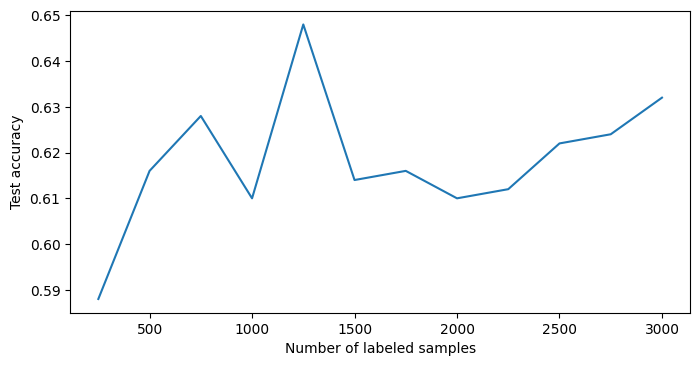

In [67]:
import matplotlib.pyplot as plt

fig = plt.figure()
fig.set_figwidth(6)
fig.set_figwidth(8)
fig.set_dpi(100)

plt.plot(n_train_arr, accuracies)
print(accuracies)

plt.xlabel("Number of labeled samples")
plt.ylabel("Test accuracy")

# Part 3: Trees
In this part of the homework, we're moving on from HMMs (Part 2) to using trees. We will practice *parsing* on sentences from a semantic parsing corpus.  

The data is obtained from this [paper](https://arxiv.org/pdf/1810.07942.pdf) (see Figure 1). As you can see from the figure, the purpose of this task is to understand what are the users *intents* from a query in plain text.  

The end goal is that given sentence to decode a binary **tree structure** with *semantic tags* as *nodes*. For example:

> whats there to do this weekend -> [<font color='00b8d4'>IN:GET_EVENT</font> whats there to do [<font color='00b8d4'>SL:DATE_TIME</font> this weekend]]  

Note that the brackets [<font color='00b8d4'>LABEL</font> a substring of the text] indicates that this span is a sub-tree and <font color='00b8d4'>LABEL</font>  is the semantic label of the root of the sub-tree. You might read more about bracket representation in this [tutorial](https://www.tutorialspoint.com/binary-tree-to-string-with-brackets-in-cplusplus). 

1. In **Part B**, we formulate this problem as a simple classification problem --- the input to the classifier will be `(text, span)` and the output will be the semantic `label` of that span. `span`  is represented by two integer `(i,j)` which are the start and the end locations of the span.

2. In **Part C**, we will implement a **CKY**-style decoding algorithm to decode the final tree based on the classifier we trained in Part B.

We did pre-processing to enable CKY-style decoding for you. This includes binarization of the trees and handling of unary rules. (see the [code](https://github.mit.edu/tianxing/mit_6864_hw3_202003)).  

Let's start by loading some dependencies and downloading the data as usual.

In [26]:
import sys
sys.path.append("hw3/trees/")
import numpy as np
import random
import torch
from torch import cuda
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from span_tree import *
seed = 0
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

if cuda.is_available():
  device = 'cuda'
  torch.cuda.manual_seed_all(seed)
else:
  print('WARNING: you are running this assignment on a cpu!')
  device = 'cpu'

## **Agenda**

We apply a model that learns the parsing structures in 4 steps.

1. Enumerating all possible spans of a sentence
2. Generating word and span embeddings
3. Learning span label classifications
4. Decoding a tree structure using the classification distributions of spans

We go through this process step by step through the homework

## **PART B**

### **Data Processing**

The very first step of the project is to load the corpus, building the **vocabulary**, **span label set**, and **span indices**. 

We first need to enumerate every node of a tree with a Depth First Search (DFS).

In [27]:
def tree_dfs(node, span_list, label_dict, mode):
    """
    The base function for the recursion:
      node: current root while traversing the tree
      span_list: keep tracks of the spans and their label encodings in the tree e.g [[(0,1), 1], [(0,6),45] ...] 
      label_dict: mapping from label to their encodings e.g {"UNK":0, "Token":1,"None":2, ... }
      mode: "train" or "eval"
    """
  
    if len(node.children) == 0:
        assert(type(node) == Token)
        cur_span = (node.index, node.index + 1)
        cur_label = label_dict['Token']
        span_list.append([cur_span, cur_label])
        return span_list, label_dict
        
    cur_span = node.get_token_span()
    cur_label = node.label
    if node.label in label_dict:
        cur_label = label_dict[node.label]
    elif mode == 'train': # we are constructing the label dictionary
        cur_label = len(label_dict)
        label_dict[node.label] = cur_label
    else:
        cur_label = label_dict['UNK']
    span_list.append([cur_span, cur_label])
    
    if len(node.children) > 1: #if only has one child, we will ignore the Token label, otherwise the token span would have two conflicting labels
        for child in node.children:
            # --------- Your code (hint: only need one single line) --------- #
            tree_dfs(child, span_list, label_dict, mode)
            # --------- Your code ends --------- # 
    return span_list, label_dict

Now, we go through the corpus and construct the **vocab dictionary** and the **label dictionary**. Note that we just add new words and labels to the dictionaries while building the training set. Unseen words or labels in validation and test set are marked as unknown (UNK).

In [28]:
def process_line(line, vocab_dict, label_dict, mode):
    '''
    Processing a line in the corpus.
    line format: Sentence \t Sentence_Tree \n
    
    Example:
        'what is the shortest way home\t
        [IN:GET_DIRECTIONS what [SUB is [SUB the [SUB shortest [SUB way [SL:DESTINATION home ] ] ] ] ] ]\n'
    
    Inputs:
    vocab_dict: vocab dictionary {word: word_index, ...}
    labels_dict: label dictionary {label: label_index, ...}
    mode: "train" or "eval"
    '''
    s, s_tree = line.strip().split('\t')
    words = s.split(' ')
    word_ids = []
    for word in words:
        if word in vocab_dict:
            word_ids.append(vocab_dict[word])
        elif mode == 'train':
            word_ids.append(len(vocab_dict))
            vocab_dict[word] = len(vocab_dict)
        else:
            word_ids.append(vocab_dict['UNK'])
    
    tree = Tree(s_tree)
    span_list = []
    span_list, label_dict = tree_dfs(tree.root.children[0], span_list, label_dict, mode)
    return word_ids, span_list, vocab_dict, label_dict

def process_corpus(corpus_path, mode, vocab_dict=None, label_dict=None):
    lines = open(corpus_path).readlines()
    if not vocab_dict:
        vocab_dict = {'UNK': 0}
    if not label_dict:
        label_dict = {'UNK': 0, 'Token': 1, 'None': 2}
    corpus = []
    sent_spans = []
    raw_lines = []
    for line in lines:
      if len(line.strip()) < 3: 
        continue
      word_ids, span_list, vocab_dict, label_dict = process_line(line, vocab_dict, label_dict, mode)
      corpus.append(word_ids)
      sent_spans.append(span_list)
      raw_lines.append(line)
    return corpus, sent_spans, vocab_dict, label_dict, raw_lines



In [29]:
corpus_train, spans_train, vocab_dict, label_dict, train_lines = process_corpus('/content/hw3/trees/train.txt', 'train')
corpus_valid, spans_valid, _, _, valid_lines = process_corpus('/content/hw3/trees/valid.txt', 'eval',
                                                 vocab_dict=vocab_dict, label_dict=label_dict)
corpus_test,  spans_test, _, _, test_lines = process_corpus('/content/hw3/trees/test.txt', 'eval',
                                                 vocab_dict=vocab_dict, label_dict=label_dict)

In [30]:
# inverted dictionaries {word_index: word, ...}
inv_vocab_dict = np.array(list(vocab_dict.keys()))
inv_label_dict = np.array(list(label_dict.keys()))

In [31]:
num_words = len(vocab_dict)
num_labels = len(label_dict)

print('Number of different words: {}'.format(num_words))
print('Number of different labels: {}'.format(num_labels))

Number of different words: 8626
Number of different labels: 147


Let see how the data looks like, and compare with our output in below:
```
['how', 'long', 'will', 'it', 'take', 'to', 'drive', 'from', 'chicago', 'to', 'mississippi']
how long will it take to drive from chicago to mississippi	[IN:GET_ESTIMATED_DURATION how [SUB long [SUB will [SUB it [SUB take [SUB to [SUB [SL:METHOD_TRAVEL drive ] [SUB from [SUB [SL:SOURCE chicago ] [SUB to [SL:DESTINATION mississippi ] ] ] ] ] ] ] ] ] ] ]

[[(0, 11), 3], [(0, 1), 1], [(1, 11), 4], [(1, 2), 1], [(2, 11), 4], [(2, 3), 1], [(3, 11), 4], [(3, 4), 1], [(4, 11), 4], [(4, 5), 1], [(5, 11), 4], [(5, 6), 1], [(6, 11), 4], [(6, 7), 5], [(7, 11), 4], [(7, 8), 1], [(8, 11), 4], [(8, 9), 6], [(9, 11), 4], [(9, 10), 1], [(10, 11), 7]]
['will', 'it', 'take', 'shorter', 'to', 'get', 'to', 'the', 'white', 'house', 'by', 'bus', 'or', 'taxi', '?']
will it take shorter to get to the white house by bus or taxi ?	[IN:UNSUPPORTED_NAVIGATION will [SUB it [SUB take [SUB shorter [SUB to [SUB get [SUB to [SUB the [SUB white [SUB house [SUB by [SUB bus [SUB or [SUB taxi ? ] ] ] ] ] ] ] ] ] ] ] ] ] ]

[[(0, 15), 8], [(0, 1), 1], [(1, 15), 4], [(1, 2), 1], [(2, 15), 4], [(2, 3), 1], [(3, 15), 4], [(3, 4), 1], [(4, 15), 4], [(4, 5), 1], [(5, 15), 4], [(5, 6), 1], [(6, 15), 4], [(6, 7), 1], [(7, 15), 4], [(7, 8), 1], [(8, 15), 4], [(8, 9), 1], [(9, 15), 4], [(9, 10), 1], [(10, 15), 4], [(10, 11), 1], [(11, 15), 4], [(11, 12), 1], [(12, 15), 4], [(12, 13), 1], [(13, 15), 4], [(13, 14), 1], [(14, 15), 1]]
['will', 'i', 'make', 'it', 'to', 'the', 'beach', 'by', 'noon', 'if', 'i', 'leave', 'now']
will i make it to the beach by noon if i leave now	[IN:GET_ESTIMATED_ARRIVAL will [SUB i [SUB make [SUB it [SUB to [SUB [SL:DESTINATION--IN:GET_LOCATION--SL:CATEGORY_LOCATION the beach ] [SUB [SL:DATE_TIME_ARRIVAL by noon ] [SUB if [SUB i [SUB leave [SL:DATE_TIME_DEPARTURE now ] ] ] ] ] ] ] ] ] ] ]

[[(0, 13), 9], [(0, 1), 1], [(1, 13), 4], [(1, 2), 1], [(2, 13), 4], [(2, 3), 1], [(3, 13), 4], [(3, 4), 1], [(4, 13), 4], [(4, 5), 1], [(5, 13), 4], [(5, 7), 10], [(5, 6), 1], [(6, 7), 1], [(7, 13), 4], [(7, 9), 11], [(7, 8), 1], [(8, 9), 1], [(9, 13), 4], [(9, 10), 1], [(10, 13), 4], [(10, 11), 1], [(11, 13), 4], [(11, 12), 1], [(12, 13), 12]]
['when', 'should', 'i', 'leave', 'my', 'house', 'to', 'get', 'to', 'the', 'hamilton', 'mall', 'right', 'when', 'it', 'opens', 'on', 'saturday']
when should i leave my house to get to the hamilton mall right when it opens on saturday	[IN:GET_ESTIMATED_DEPARTURE when [SUB should [SUB i [SUB leave [SUB [SL:SOURCE--IN:GET_LOCATION_HOME [SL:CONTACT my ] house ] [SUB to [SUB get [SUB to [SUB [SL:DESTINATION--IN:GET_LOCATION--SL:POINT_ON_MAP the [SUB hamilton mall ] ] [SL:DATE_TIME_ARRIVAL right [SUB when [SUB it [SUB opens [SUB on saturday ] ] ] ] ] ] ] ] ] ] ] ] ] ]

[[(0, 18), 13], [(0, 1), 1], [(1, 18), 4], [(1, 2), 1], [(2, 18), 4], [(2, 3), 1], [(3, 18), 4], [(3, 4), 1], [(4, 18), 4], [(4, 6), 14], [(4, 5), 15], [(5, 6), 1], [(6, 18), 4], [(6, 7), 1], [(7, 18), 4], [(7, 8), 1], [(8, 18), 4], [(8, 9), 1], [(9, 18), 4], [(9, 12), 16], [(9, 10), 1], [(10, 12), 4], [(10, 11), 1], [(11, 12), 1], [(12, 18), 11], [(12, 13), 1], [(13, 18), 4], [(13, 14), 1], [(14, 18), 4], [(14, 15), 1], [(15, 18), 4], [(15, 16), 1], [(16, 18), 4], [(16, 17), 1], [(17, 18), 1]]
['i', 'need', 'to', 'know', 'if', 'there', "'s", 'a', 'lot', 'of', 'traffic', 'on', 'my', 'way', 'home']
i need to know if there 's a lot of traffic on my way home	[IN:GET_INFO_TRAFFIC i [SUB need [SUB to [SUB know [SUB if [SUB there [SUB 's [SUB a [SUB lot [SUB of [SUB traffic [SUB on [SUB my [SUB way [SL:DESTINATION--IN:GET_LOCATION_HOME home ] ] ] ] ] ] ] ] ] ] ] ] ] ] ]

[[(0, 15), 17], [(0, 1), 1], [(1, 15), 4], [(1, 2), 1], [(2, 15), 4], [(2, 3), 1], [(3, 15), 4], [(3, 4), 1], [(4, 15), 4], [(4, 5), 1], [(5, 15), 4], [(5, 6), 1], [(6, 15), 4], [(6, 7), 1], [(7, 15), 4], [(7, 8), 1], [(8, 15), 4], [(8, 9), 1], [(9, 15), 4], [(9, 10), 1], [(10, 15), 4], [(10, 11), 1], [(11, 15), 4], [(11, 12), 1], [(12, 15), 4], [(12, 13), 1], [(13, 15), 4], [(13, 14), 1], [(14, 15), 18]]
```

In [32]:
for i in range(5):
  print([inv_vocab_dict[w] for w in corpus_train[i]])
  print(train_lines[i], end="")
  print(spans_train[i])
  print()

['how', 'long', 'will', 'it', 'take', 'to', 'drive', 'from', 'chicago', 'to', 'mississippi']
how long will it take to drive from chicago to mississippi	[IN:GET_ESTIMATED_DURATION how [SUB long [SUB will [SUB it [SUB take [SUB to [SUB [SL:METHOD_TRAVEL drive ] [SUB from [SUB [SL:SOURCE chicago ] [SUB to [SL:DESTINATION mississippi ] ] ] ] ] ] ] ] ] ] ]
[[(0, 11), 3], [(0, 1), 1], [(1, 11), 4], [(1, 2), 1], [(2, 11), 4], [(2, 3), 1], [(3, 11), 4], [(3, 4), 1], [(4, 11), 4], [(4, 5), 1], [(5, 11), 4], [(5, 6), 1], [(6, 11), 4], [(6, 7), 5], [(7, 11), 4], [(7, 8), 1], [(8, 11), 4], [(8, 9), 6], [(9, 11), 4], [(9, 10), 1], [(10, 11), 7]]

['will', 'it', 'take', 'shorter', 'to', 'get', 'to', 'the', 'white', 'house', 'by', 'bus', 'or', 'taxi', '?']
will it take shorter to get to the white house by bus or taxi ?	[IN:UNSUPPORTED_NAVIGATION will [SUB it [SUB take [SUB shorter [SUB to [SUB get [SUB to [SUB the [SUB white [SUB house [SUB by [SUB bus [SUB or [SUB taxi ? ] ] ] ] ] ] ] ] ] ] ] ] ] ]


### **Defining the Neural Network**

#### **Sentence Encoding**

We use a Bi-directional LSTM for sentence encoding. We build a sentence encoder with a embedding layer and a Bi-directional LSTM layer:

- Input: 
 - word indices: `[batch_size, sentence_length]`
- Output: 
  - word embeddings: `[batch_size, sentence_length, 2*hidden_size]`

In [33]:
class SentEnc(nn.Module):
    def __init__(self, num_words, num_layers, hidden_size, dropout=0):
        super(SentEnc, self).__init__()
    
        self.embedding = nn.Embedding(num_words, hidden_size)
        # --------- Your code --------- #
        # Construct your lstm module here (single line):
        self.lstm = nn.LSTM(input_size=hidden_size,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            dropout=dropout,
                            bidirectional=True,
                            batch_first=True)
        # --------- Your code ends --------- #
    
    def forward(self, x):
        '''
        x: [batch_size, entence_length] matrix of word indices
        This function should return a matrix of 
        [batch_size, sentence_length, 2*hidden_size] word embeddings. 
        '''
        # --------- Your code --------- #
        # Hint: remember to pass the inputs through the embedding layer! 
        outputs = self.embedding(x)
        outputs, _ = self.lstm(outputs)

        # --------- Your code ends --------- #
        return outputs

### **Span Encodings**

Given the LSTM outputs, we generate the span embeddings with the span indices.

We generate a span embedding by concatenating the word embeddings of the first and last words of a span. For example, if a span starts from the i-th word and ends at the j-th word, our span embedding would be

$$[h_i^T; h_{j-1}^T]^T$$

where $h_i$ stands for the Bi-LSTM output of the $i^{th}$ word. Note that span_ij is inclusive to i but exclusive to j, as would be the output if you sliced a Python list A[i:j]. 


In Pytorch, Given the hidden states $h[0], h[1], ..., h[n]$, where
```
h[i].size() = [1, k]
```
the embedding of span (i, j) is
```
span_ij = torch.cat([h[i], h[j-1]], dim=1)
span_ij.size() = [1, 2 * k]
```
Please complete the following function for generating span embeddings.

- Input: 
 - word embeddings: `[sentence_length, hidden_size]` 
 - span indices: `[num_span, 2]`
- Output: 
 - span embeddings `[num_span, hidden_size * 2]`



In [34]:
def get_span_embeddings(word_embeddings, span_indices):
    '''
    word_embeddings: [sentence_length, hidden_size] matrix of each word's' embeddings from the sentence
    span_indices: [num_span, 2] matrix of all span indices
    '''
    # --------- Your code --------- #
    sentence_length, hidden_size = word_embeddings.shape
    num_span = span_indices.size(0)
    span_embeddings = torch.zeros((num_span, hidden_size * 2)).to(device)
    for i in range(num_span):
        span_begin = span_indices[i, 0]
        span_end = span_indices[i, 1] - 1
        span_embeddings[i] = torch.cat([word_embeddings[span_begin], word_embeddings[span_end]], dim=-1)
    return span_embeddings
    # --------- Your code ends --------- #

### **Tag Prediction**

We build a Classifier that puts the neural models together. The classifier takes word and span indices as inputs, and predict span labels by calculating word embeddings, span embeddings, and label logits. we will predict the tag of the spans with a linear classifier.

- Inputs: 
 - word indices: `[batch_size, num_words]`
- Outputs: 
 - span predictions: `[num_spans, num_labels]`

Please implement the forward function following 4 steps:
1. Generate the word embeddings by processing the input sentences with the LSTM sentence encoder.
2. Apply dropout on word embeddings.
3. Calculate span embeddings with function get_span_embeddings().
4. Calculate label logits with the linear layer defined as follows.


In [35]:
class Classifier(nn.Module):
    
    def __init__(self, num_words, num_labels, num_layers, hidden_size, dropout=0):
        super(Classifier, self).__init__()
        self.sent_enc = SentEnc(num_words, num_layers, hidden_size)
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(4 * hidden_size, num_labels)
    
    def forward(self, x, span_indices):
      '''
      x: [batch_size, num_words] matrix of the word indices
      span_indices: [num_spans, 2] matrix of the span indices
      This function should return a matrix of [num_spans, num_labels] where
      each row contains the label logits corresponding to the relevant span. 
      You can assume batch_size is 1.
      '''
      # --------- Your code --------- #
      x = self.sent_enc(x)
      x = self.dropout(x)
      span_embeddings = get_span_embeddings(x[0], span_indices)
      logits = self.linear(span_embeddings)
      
      # --------- Your code ends --------- #
      return logits

In [36]:
#For decoding, we add some random spans and label them as "None"
def add_none_span(word_list, span_list, label_dict, all=False):
    num_words = len(word_list)
    num_labeled_span = len(span_list)
    labeled_span_set = set([span for span, label in span_list])
    none_spans = []
    for i in range(num_words):
        for j in range(i + 1, num_words):
            if (i, j) not in labeled_span_set:
                none_spans.append([(i, j), label_dict['None']])
    if not all:
        k = min(num_labeled_span, len(none_spans))
        sampled_none_spans = random.sample(none_spans, k)
    else:
        sampled_none_spans = none_spans
    return span_list + sampled_none_spans

### **Training Loop**

With all neural models already defined, we can now implement the training loop.

In [37]:
print('Using device: {}'.format(device))


# just remember you can tune these hyper-parameters!
batch_size = 1
num_layers = 2
hidden_size = 200
lr = 0.05
num_epochs = 3 # Be aware of over-fitting!
loss_fn = nn.CrossEntropyLoss().to(device)
dropout = 0.25

classifier = Classifier(num_words, num_labels, num_layers, hidden_size, dropout)
print(classifier)
optimizer = optim.SGD(classifier.parameters(), lr=lr, momentum=0.9)

classifier = classifier.to(device)
classifier.train()

for epoch in range(num_epochs):
    total_loss = 0
    classifier.train()
    for i in tqdm(range(len(corpus_train))):

        if i % 10000 == 0:
            print('Epoch {} Batch {}'.format(epoch, i))
        
        cur_spans = add_none_span(corpus_train[i], spans_train[i], label_dict)
        
        sent_inputs  = torch.Tensor([corpus_train[i]]).long().to(device)
        span_indices = torch.Tensor([x[0] for x in cur_spans]).long().to(device)
        span_labels  = torch.Tensor([x[1] for x in cur_spans]).long().to(device)
        
          # This should follow the same training process from past homeworks. Don't
        # forget to increment your total_loss! 
        # --------- Your code --------- #

        preds = classifier(sent_inputs, span_indices)

        loss = loss_fn(preds, span_labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        total_loss += loss.item()


        # --------- Your code ends --------- #
    print('Epoch {}, train loss={}'.format(epoch, total_loss / len(corpus_train)))

    total_loss = 0
    classifier.eval()
    for i in tqdm(range(len(corpus_valid))):
        #if i % 10000 == 0:
        #    print('Epoch {} Batch {}'.format(epoch, i))
        cur_spans = add_none_span(corpus_valid[i], spans_valid[i], label_dict)
        
        sent_inputs  = torch.Tensor([corpus_valid[i]]).long().to(device)
        span_indices = torch.Tensor([x[0] for x in cur_spans]).long().to(device)
        span_labels  = torch.Tensor([x[1] for x in cur_spans]).long().to(device)
        
        # This is very similar to the training steps above, but you won't need to
        # back-propogate and update weights during validation.
        # --------- Your code --------- #

        preds = classifier(sent_inputs, span_indices)
        loss = loss_fn(preds, span_labels)

        total_loss += loss.item()

        # --------- Your code ends --------- #
    print('Epoch {}, valid loss={}'.format(epoch, total_loss / len(corpus_valid)))

Using device: cuda
Classifier(
  (sent_enc): SentEnc(
    (embedding): Embedding(8626, 200)
    (lstm): LSTM(200, 200, num_layers=2, batch_first=True, bidirectional=True)
  )
  (dropout): Dropout(p=0.25, inplace=False)
  (linear): Linear(in_features=800, out_features=147, bias=True)
)


  0%|          | 0/31279 [00:00<?, ?it/s]

Epoch 0 Batch 0


 32%|███▏      | 10020/31279 [01:47<03:38, 97.16it/s]

Epoch 0 Batch 10000


 64%|██████▍   | 20012/31279 [03:35<02:07, 88.63it/s]

Epoch 0 Batch 20000


 96%|█████████▌| 30020/31279 [05:24<00:12, 97.72it/s]

Epoch 0 Batch 30000


100%|██████████| 31279/31279 [05:37<00:00, 92.65it/s]


Epoch 0, train loss=0.19886971725613117


100%|██████████| 4462/4462 [00:20<00:00, 220.72it/s]


Epoch 0, valid loss=0.10116364356324448


  0%|          | 8/31279 [00:00<07:04, 73.68it/s]

Epoch 1 Batch 0


 32%|███▏      | 10012/31279 [01:49<03:47, 93.30it/s]

Epoch 1 Batch 10000


 64%|██████▍   | 20014/31279 [03:36<02:10, 86.30it/s]

Epoch 1 Batch 20000


 96%|█████████▌| 30019/31279 [05:24<00:13, 96.31it/s]

Epoch 1 Batch 30000


100%|██████████| 31279/31279 [05:37<00:00, 92.78it/s]


Epoch 1, train loss=0.09100156822784086


100%|██████████| 4462/4462 [00:21<00:00, 209.18it/s]


Epoch 1, valid loss=0.08298133122400654


  0%|          | 8/31279 [00:00<07:25, 70.12it/s]

Epoch 2 Batch 0


 32%|███▏      | 10013/31279 [01:47<03:35, 98.85it/s]

Epoch 2 Batch 10000


 64%|██████▍   | 20015/31279 [03:35<02:07, 88.11it/s]

Epoch 2 Batch 20000


 96%|█████████▌| 30015/31279 [05:22<00:14, 89.96it/s]

Epoch 2 Batch 30000


100%|██████████| 31279/31279 [05:36<00:00, 92.97it/s] 


Epoch 2, train loss=0.06274110535926637


100%|██████████| 4462/4462 [00:20<00:00, 222.57it/s]

Epoch 2, valid loss=0.08049911542311732


### **Evaluation**

After training the model, we evaluate the classification results.  
What we will do is that we treat a tree strcture as a bag of spans (a list of span indices), and then compute F-1 score.  
The staff solution computed precision near 0.85, recall near 0.94, f1 near 0.89, and exact_match near 0.42.

In [38]:
from itertools import zip_longest
from typing import Counter, Dict, Optional
import numpy as np

class Calculator:
    def __init__(self, strict = False) -> None:
        self.TP = 0
        self.gold_P = 0
        self.pred_P = 0      
        self.exact_match = []
        self.tree_match = []
        self.well_form = []
        self.strict = strict

    def get_metrics(self):
        precision = (self.TP / self.pred_P) if self.pred_P else 0
        recall = (self.TP / self.gold_P) if self.gold_P else 0
        f1 = (2.0 * precision * recall / (precision + recall)) if (precision + recall) else 0
     
        return {
            "precision": precision,
            "recall": recall,
            "f1": f1,
            "exact_match": np.mean(self.exact_match),
            "well_form": np.mean(self.well_form),
            "tree_match":  np.mean(self.tree_match),
            "num_examples": len(self.exact_match)
        }
    
    def is_well_formed(self, spans):   
        for s1 in spans: 
          for s2 in spans:
              if s1[0] < s2[0] and s2[0] < s1[1] and s1[1] < s2[1]:
                    return False
        return True

    def add_instance_span(self, gold_spans, pred_spans):
        self.gold_P += len(gold_spans)
        self.pred_P += len(pred_spans)
        self.TP += len(set(gold_spans) & set(pred_spans))
        self.exact_match.append(int(set(gold_spans) == set(pred_spans)))
        gold_spans = [s[0] for s in gold_spans]
        pred_spans = [s[0] for s in pred_spans]
        self.tree_match.append(int(set(gold_spans) == set(pred_spans)))
        well_formed = self.is_well_formed(pred_spans)
        self.well_form.append(int(well_formed))

    def add_instance_tree(self, gold_tree, pred_tree):
        node_info_gold = self._get_node_info(gold_tree)
        self.gold_P += len(node_info_gold)
        node_info_pred = self._get_node_info(pred_tree)
        self.pred_P += len(node_info_pred)
        self.TP += len(node_info_gold & node_info_pred)
        self.exact_match.append(int(node_info_gold.keys() == node_info_pred.keys()))
        self.well_form.append(1) #we assume the decoded tree is indeed a tree :)
        node_info_gold = {k[1] for k,v in node_info_gold.items()}
        node_info_pred = {k[1] for k,v in node_info_pred.items()}
        self.tree_match.append(int(node_info_gold==node_info_pred))
        
    def _get_node_info(self, tree) -> Counter:
        nodes = tree.root.list_nonterminals()
        node_info: Counter = Counter()
        for node in nodes:
            if node.label != 'Token':
              span = self._get_span(node)
              node_info[(node.label, self._get_span(node))] += 1 

        return node_info

    def _get_span(self, node):
        return node.get_flat_str_spans(
        ) if self.strict else node.get_token_span()

In [39]:
classifier.eval()
partb_calc = Calculator(strict=False)
pred_bag_spans = []
gold_bag_spans = []
for (tokens, spans, line) in zip(corpus_test,spans_test,test_lines):   
    #We only test non-Token labels
    spans = [tuple(x) for x in spans if x[1] != 1]

    if len(spans) <= 1 or len(line.strip()) < 3: 
      continue

    all_spans = [(i,j) for i in range(len(tokens)) 
                        for j in range(i + 1, len(tokens) + 1)]

    input  = torch.Tensor([tokens]).long().to(device)
    logits = classifier(input, torch.Tensor(all_spans).long().to(device))

    pred_spans = []
    for i, span in enumerate(all_spans):
        label_idx = torch.argmax(logits[i]).item()
        if label_idx != 2 and label_idx != 1:
          pred_spans.append((span,label_idx))
    
    partb_calc.add_instance_span(spans, pred_spans)
    pred_bag_spans.append(pred_spans)
    gold_bag_spans.append(spans)
 
print(partb_calc.get_metrics())

{'precision': 0.8490942277460672, 'recall': 0.9437024355351259, 'f1': 0.8939020326557814, 'exact_match': 0.41647215738579524, 'well_form': 0.5489607646993442, 'tree_match': 0.48338335000555743, 'num_examples': 8997}


## **PART C** (Only for 6.864 students)
The remaining will be **Part C** for **HW3-Trees**.  
In Part C, we will decode a tree based on the classifier trained on Part B.  


### **CKY**  
You will be implementing the following simple CYK recursion:  
```best_score[i,j]=max_k {best_score[i,k]+best_score[k,j]} + max_l {span_dict[(i,j)][l]}```      
where `l` is the label of the current span `(i,j)`, and `k` is the splitting point. `k` is inclusive to the right span. 

Note that this is a simpler recursion than the full CKY algorithm.

In [ ]:
from torch.nn.functional import log_softmax
EPS = 1e-6
dp_results = []
classifier.eval()
for kk,(line,spans,tokens) in enumerate(zip(test_lines,spans_test,corpus_test)):
    spans = [tuple(x) for x in spans if  x[1] != 1]
    
    if len(spans) <= 1 or len(line.strip()) < 3: 
      continue
    
    sent_inputs  = torch.Tensor([tokens]).long().to(device)
    
    all_spans = [(i,j) for i in range(len(tokens)) 
                         for j in range(i + 1, len(tokens) + 1)]
    
    logits = classifier(sent_inputs, torch.Tensor(all_spans).long().to(device))
    logprobs = log_softmax(logits, dim = -1)
    # span dict will map each span (l,r) to its predicted distribution of labels
    span_dict = {}
    for i, s in enumerate(all_spans): 
      span_dict[s]  = logprobs[i] 
  
    TOKEN_ID, NULL_ID = 1, 2
    best_score, best_split, best_label = {}, {}, {} # we will do dynamic programming to decode a binary tree out of our predictions
    # Think: why do we first iterate the length of the span?
    for ll in range(1, len(tokens) + 1): # length of the span
        for i in range(0, len(tokens)-ll+1): # start of the span
            j = i + ll
            cur_span = (i, j)
            if j == i + 1:
                span_dict[cur_span][NULL_ID]  = -1/EPS
                # --------- Your code --------- #
                #use span_dict[cur_span] to update best_label and best_score              

                
                # --------- Your code ends --------- #
                best_split[cur_span] = None
            else:
                span_dict[cur_span][NULL_ID]  = -1/EPS # we will never decode a NULL sub-tree
                span_dict[cur_span][TOKEN_ID] = -1/EPS # we will never decode a NULL sub-tree
                # --------- Your code --------- #
                #try to give the values for best_score/label/split[cur_span] using the 
                # recursive equation above



                # --------- Your code ends --------- #
            #print(cur_span, best_score[cur_span], best_label[cur_span])
    dp_results.append((best_score, best_split, best_label))
print(len(dp_results))

### **Tree Construction**
In this section, we will construct a tree using the DP results.  
The code relies on a `Node` class defined in `span_tree.py`. Each `Node` object has `children`, `parent`, and `label` attributes, where `children` is a `List`, `parent` is an optional `Node`, and `label` is a `str`. 

You won't need more than this to fill out the code, but feel free to look more into `span_tree.py` for a better understanding.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import sys
def get_nodetype(label):
    if label.startswith(PREFIX_INTENT):
        node = Intent(label)
    elif label.startswith(PREFIX_SLOT):
        node = Slot(label)
    elif label.startswith(PREFIX_SUBTREE):
        node = SubTree(label)
    else:
        print('something wrong with the label!!!', label)
        sys.error()
    return node

def dfs_build(l, r, best_label, best_split):
  '''
  l: integer representing left (inclusive) index of span
  r: integer representing right (non-inclusive) index of span
  best_label: {span: label_index} dictionary created in dp_results
  best_split: {span: split} dictionary created in dp_results
  This function returns the node for the given span, recursively 
  creating all children nodes below it. 
  '''
    if l + 1 == r:
        la = best_label[(l,r)]
        if la == 1:
            return Token(surface_tokens[l], l)
        else:
            node = get_nodetype(inv_label_dict[la])
            node.children = [Token(surface_tokens[l], l)]
            node.children[0].parent = node
            return node

    label = inv_label_dict[best_label[(l, r)]]
    node = get_nodetype(label)
    
    #--- your code --- #
    #hint: use best_split! and recursion to assign node.children here


    #--- your code ends --- #

    for c in node.children:
        c.parent = node
    
    return node


In [ ]:
pred_trees = []
gold_trees = []
partc_calc = Calculator(strict=False)
k = 0
for i,(line,spans,tokens) in enumerate(zip(test_lines,spans_test,corpus_test)):
    surface_tokens, str_ref_tree = line.strip().split('\t')
    surface_tokens = surface_tokens.split()
    spans = [tuple(x) for x in spans if x[1] != 1]

    if len(spans) <= 1 or len(line.strip()) < 3: 
      continue

    best_score, best_split, best_label = dp_results[k]
    k+=1
    root = Root()
    root.children = [dfs_build(0, len(tokens), best_label, best_split)]
    root.children[0].parent = root
    tree = Tree('IN:GET_EVENT placeholder') #the string here is just a placeholder
    tree.root = root
    if k < 10: #use this info for debugging! Does your tree make sense?
        print(k, line.strip())
        print('REF:', str_ref_tree)
        print('DEC:', str(tree))
        print()
    """ here's some decoding examples we get
      1 whats there to do this weekend	[IN:GET_EVENT whats [SUB there [SUB to [SUB do [SL:DATE_TIME this weekend ] ] ] ] ]
      REF: [IN:GET_EVENT whats [SUB there [SUB to [SUB do [SL:DATE_TIME this weekend ] ] ] ] ]
      DEC: [IN:GET_EVENT whats [SUB there [SUB to [SUB do [SL:DATE_TIME this weekend ] ] ] ] ]

      2 what is a good restaurant for tex mex in austin	[IN:UNSUPPORTED what [SUB is [SUB a [SUB good [SUB restaurant [SUB for [SUB tex [SUB mex [SUB in austin ] ] ] ] ] ] ] ] ]
      REF: [IN:UNSUPPORTED what [SUB is [SUB a [SUB good [SUB restaurant [SUB for [SUB tex [SUB mex [SUB in austin ] ] ] ] ] ] ] ] ]
      DEC: [IN:UNSUPPORTED what [SUB is [SUB a [SUB good [SUB restaurant [SUB for [SUB tex [SUB mex [SUB in austin ] ] ] ] ] ] ] ] ]

      3 where can i see the fireworks tonight	[IN:GET_EVENT where [SUB can [SUB i [SUB see [SUB [SL:CATEGORY_EVENT the fireworks ] [SL:DATE_TIME tonight ] ] ] ] ] ]
      REF: [IN:GET_EVENT where [SUB can [SUB i [SUB see [SUB [SL:CATEGORY_EVENT the fireworks ] [SL:DATE_TIME tonight ] ] ] ] ] ]
      DEC: [IN:GET_EVENT where [SUB can [SUB i [SUB see [SUB the [SUB fireworks [SL:DATE_TIME tonight ] ] ] ] ] ] ]
    """
    partc_calc.add_instance_tree(Tree(str_ref_tree), tree)
    pred_trees.append(tree)
    gold_trees.append(Tree(str_ref_tree))

Once again, we'll look at the metrics. 
The staff solution computed precision near 0.87, recall near 0.86, f1 near 0.87, and exact_match near 0.44. 

In [ ]:
print(partc_calc.get_metrics())


Recommended Reading (not required, just for interested students):  
https://arxiv.org/pdf/1810.07942.pdf  
https://www.aclweb.org/anthology/D16-1257/  
https://arxiv.org/abs/1412.7449  